# Setup

In [1]:
import tensorflow as tf
import os

In [2]:
print(tf.config.experimental.list_physical_devices('GPU'))

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [3]:
gpus = tf.config.experimental.list_physical_devices('GPU')
for gpu in gpus:
    tf.config.experimental.set_memory_growth(gpu, True)

# Data Augmentation

In [1]:
from tensorflow.keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator

In [2]:
datagen = ImageDataGenerator(
    rotation_range=5,
    shear_range=0.1,
    zoom_range=0.2,
    horizontal_flip=True,
    width_shift_range=0.1,
    height_shift_range=0.1
)

In [3]:
def generate_augmentation(source_dir, destination_dir):
    for pic in os.listdir(source_dir):
        img = image.load_img(os.path.join(source_dir, pic), target_size=(200,200))
        img = image.img_to_array(img)
        
        input_batch = img.reshape(1,200,200,3)
        
        i = 0
        for output in datagen.flow(input_batch, batch_size=1, save_to_dir=destination_dir):
            i += 1
            if i == 5:
                break

In [4]:
generate_augmentation(os.path.join('data','missing'), os.path.join('aug_data','missing'))
generate_augmentation(os.path.join('data','spring_assembly'), os.path.join('aug_data','spring_assembly'))

# Loading Data

In [18]:
import numpy as np
import matplotlib.pyplot as plt

In [68]:
data = tf.keras.utils.image_dataset_from_directory('data')

Found 301 files belonging to 2 classes.


In [69]:
data_iterator = data.as_numpy_iterator()

In [70]:
batch = data_iterator.next()

In [71]:
batch[0].shape

(32, 256, 256, 3)

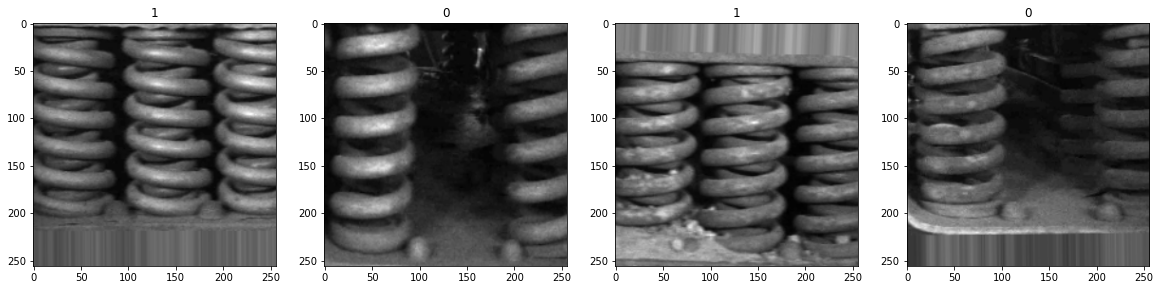

In [75]:
fig, ax = plt.subplots(1,4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img.astype(int))
    ax[idx].title.set_text(batch[1][idx])

In [ ]:
# class 0 = missing
# class 1 = spring_assembly

# Preprocessing

In [56]:
data = data.map(lambda x,y: (x/255, y))

In [57]:
scaled_iterator = data.as_numpy_iterator()

In [58]:
batch = scaled_iterator.next()

In [59]:
batch[0].max()

1.0

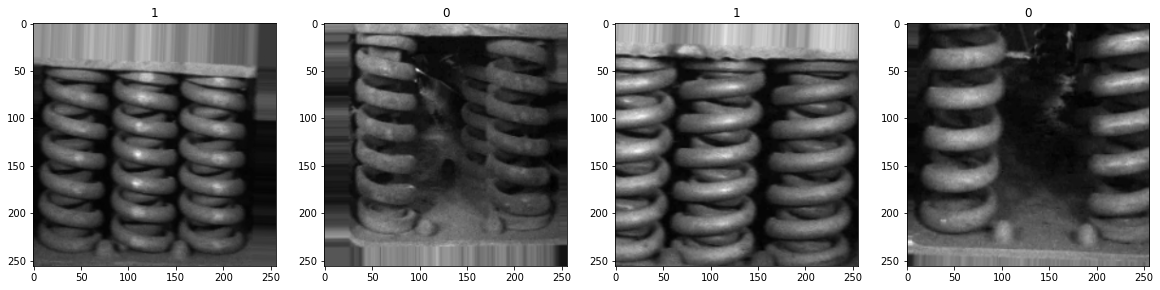

In [63]:
fig, ax = plt.subplots(1,4, figsize=(20,20))
for idx, img in enumerate(batch[0][:4]):
    ax[idx].imshow(img)
    ax[idx].title.set_text(batch[1][idx])

# train_test_split

In [16]:
len(data)

10

In [17]:
train_size = int(len(data) * .7)
val_size = int(len(data) * .2)
test_size = int(len(data) * .1)

In [18]:
train_size + val_size + test_size

10

In [19]:
train = data.take(train_size)
val = data.skip(train_size).take(val_size)
test = data.skip(train_size + val_size).take(test_size)

# Building Model

In [8]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dense, Flatten

In [21]:
model = Sequential()

model.add(Conv2D(16,(3,3),1, activation = 'relu', input_shape = (256,256,3)))
model.add(MaxPooling2D())

model.add(Conv2D(32,(3,3),1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Conv2D(16,(3,3),1, activation = 'relu'))
model.add(MaxPooling2D())

model.add(Flatten())

model.add(Dense(256, activation = 'relu'))
model.add(Dense(1, activation = 'sigmoid'))

In [22]:
model.compile('adam',loss = tf.losses.BinaryCrossentropy(), metrics=['accuracy'])

In [9]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 254, 254, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 127, 127, 16)     0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (None, 125, 125, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 62, 62, 32)       0         
 2D)                                                             
                                                                 
 conv2d_2 (Conv2D)           (None, 60, 60, 16)        4624      
                                                                 
 max_pooling2d_2 (MaxPooling  (None, 30, 30, 16)       0

# Training

In [24]:
logdir = 'logs'

In [25]:
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir = logdir)

In [26]:
hist = model.fit(train, epochs=25, validation_data=val, callbacks=[tensorboard_callback])

Epoch 1/25
7/7 [==============================] - 9s 166ms/step - loss: 0.6072 - accuracy: 0.6116 - val_loss: 0.4752 - val_accuracy: 0.9219
Epoch 2/25
7/7 [==============================] - 1s 139ms/step - loss: 0.3773 - accuracy: 0.9375 - val_loss: 0.3166 - val_accuracy: 0.8906
Epoch 3/25
7/7 [==============================] - 1s 139ms/step - loss: 0.2852 - accuracy: 0.9420 - val_loss: 0.1701 - val_accuracy: 0.9375
Epoch 4/25
7/7 [==============================] - 1s 139ms/step - loss: 0.2838 - accuracy: 0.9241 - val_loss: 0.2441 - val_accuracy: 0.9219
Epoch 5/25
7/7 [==============================] - 1s 141ms/step - loss: 0.2017 - accuracy: 0.9554 - val_loss: 0.3140 - val_accuracy: 0.9062
Epoch 6/25
7/7 [==============================] - 1s 139ms/step - loss: 0.1627 - accuracy: 0.9732 - val_loss: 0.0725 - val_accuracy: 1.0000
Epoch 7/25
7/7 [==============================] - 1s 143ms/step - loss: 0.0712 - accuracy: 0.9821 - val_loss: 0.1013 - val_accuracy: 0.9844
Epoch 8/25
7/7 [====

# Plot Performance

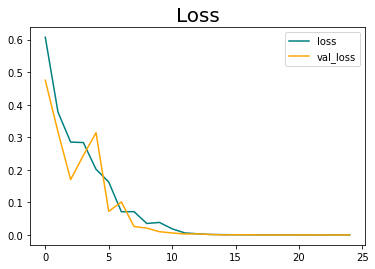

In [31]:
plt.plot(hist.history['loss'], color='teal', label='loss')
plt.plot(hist.history['val_loss'], color='orange', label='val_loss')
plt.title('Loss', fontsize=20)
plt.legend()
plt.show()

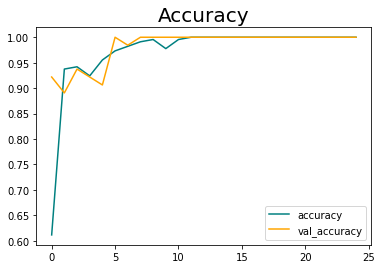

In [34]:
plt.plot(hist.history['accuracy'], color='teal', label='accuracy')
plt.plot(hist.history['val_accuracy'], color='orange', label='val_accuracy')
plt.title('Accuracy', fontsize=20)
plt.legend()
plt.show()

# Prediction

In [16]:
os.listdir(os.path.join('data','missing'))[0]

'1697055224426.jpg'

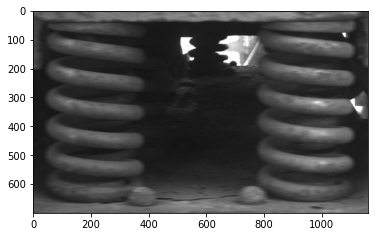

In [33]:
import cv2

img = cv2.imread(os.path.join('data','missing',os.listdir(os.path.join('data','missing'))[6]))
plt.imshow(img)
# plt.imshow(cv2.cvtColor(img, cv2.COLOR_BGR2RGB))
plt.show()

In [34]:
img.shape

(700, 1160, 3)

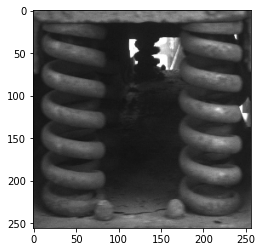

In [35]:
resize = tf.image.resize(img, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [39]:
model.predict(np.expand_dims(resize/255, 0))

1/1 [==============================] - 3s 3s/step


array([[1.5278151e-07]], dtype=float32)

# Save the Model

In [6]:
from tensorflow.keras.models import load_model

In [36]:
model.save('springClassification.h5')

# Loading the Model

In [7]:
model = load_model('springClassification.h5')